## Setup Cells

In [0]:
!pip install spotipy
!pip install langdetect
!pip install spotify-token

     |████████████████████████████████| 1.0MB 2.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=4453f8193aa84f10aa647bd2f8a7fbaaad5559d6a51cf463c736c983ed5c76e9
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [0]:
import pickle
import spotify_token as st
import spotipy as sp
import json
import numpy as np
import pandas as pd
import random


from collections import Counter
from itertools import chain
from time import sleep
from langdetect import detect
from tqdm import trange
from spotipy.oauth2 import SpotifyClientCredentials

SPOTIPY_CLIENT_ID=''
SPOTIPY_CLIENT_SECRET=''
SPOTIPY_REDIRECT_URI='http://example.com'

def save(obj, filename):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)
  print("Saved at {}!".format(filename))
    
def load(filename):
  with open(filename, 'rb') as f:
    obj = pickle.load(f) 
  return obj

## Login OAuth

In [0]:
data = st.start_session(input("Username: "), input("Password: "))
access_token = data[0]
expiration_date = data[1]

spotify = sp.Spotify(access_token)

## Get list of saved track item JSON

In [0]:
def get_all_saved_tracks(sp):
  results = sp.current_user_saved_tracks()
  tracks = results['items']
  while results['next']:
      results = sp.next(results)
      tracks.extend(results['items'])
  return tracks

items = [item['track'] for item in get_all_saved_tracks(spotify)]

## Get Audio Features JSON for each track item

In [0]:
def get_audio_features_list(spotify, track_ids):
  num_tracks = len(track_ids)
  audio_features = []
  step = 50
  for i in trange(0, num_tracks, step):
     audio_features.extend(spotify.audio_features(track_ids[i:min(i+step,num_tracks)]))
  return audio_features
  
track_ids = [item['id'] for item in items]
audio_features = get_audio_features_list(spotify, track_ids)

100%|██████████| 24/24 [00:01<00:00, 15.33it/s]


## Parse JSON to dictionary of audio data

In [0]:
TRACK_FEATURES = ['id', 'energy', 'danceability', 'liveness', 
                  'instrumentalness', 'acousticness', 'loudness', 'speechiness', 'tempo', 'valence',
                  'key', 'mode', 'duration_ms']
                  
def get_track_data_with_audio_features(audio_features):
  # Initialize empty dict.
  track_data = dict.fromkeys(TRACK_FEATURES, 0)
  for k in track_data.keys(): track_data[k] = []
  
  # Update all relevant track features
  for af in audio_features:
    for k, v in af.items():
      if k in track_data: track_data[k].append(v)
  return track_data

audio_data = get_track_data_with_audio_features(audio_features)

## Get artist and track names and merge with audio dictionary

In [0]:
def get_track_name_dict(track_items): 
  track_name_dict = dict(name=[], artist=[])
  for track in track_items:
    artists = [artist['name'] for artist in track['artists']]
    track_name_dict['name'].append(track['name'])
    track_name_dict['artist'].append(artists)
  return track_name_dict
    
track_name_dict = get_track_name_dict(items)
track_data = audio_data.copy()
track_data.update(track_name_dict)
track_data['popularity'] = [item['popularity'] for item in items]
save(track_data,"track_data.pkl")

Saved at track_data.pkl!


##Lyric Scraping code

In [0]:
import requests
from bs4 import BeautifulSoup

token = ""
def request_song_info(song_title, artist_name):
  base_url = 'https://api.genius.com'
  headers = {'Authorization': 'Bearer ' + token}
  search_url = base_url + '/search'
  data = {'q': song_title + ' ' + artist_name}
  response = requests.get(search_url, data=data, headers=headers)

  return response
  
def scrape_song_url(url):
  page = requests.get(url)
  html = BeautifulSoup(page.text, 'html.parser')
  lyrics = html.find('div', class_='lyrics').get_text()
  return lyrics

def extract_lyrics(song_title, artist_name):
  # Search for matches in the request response
  response = request_song_info(song_title, artist_name)
  json = response.json()
  remote_song_info = None
  
  if json:
    for hit in json['response']['hits']:
      if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
        remote_song_info = hit
        break
    
    # Extract lyrics from URL if the song was found
    if remote_song_info:
      song_url = remote_song_info['result']['url']
      return scrape_song_url(song_url)
  
  return "NA"

## Scrape lyrics for all songs

In [0]:
def get_lyrics(names, artists):
  lyrics = load('lyrics_dict.pkl')
  lyrics_list = []  
  for i in trange(len(names)):
    name, artist = names[i], artists[i]
    key = "{},{}".format(name, ",".join(artist))
    if lyrics.get(key, 0) == 0:
      lyrics[key] = extract_lyrics(name, artist[0])
      
    lyrics_list.append(lyrics[key])
    if i % 1000 == 0: 
      save(lyrics, "lyrics_dict.pkl")
    
  return lyrics, lyrics_list
  
track_data = load('track_data.pkl')

lyric_dict, lyric_list = get_lyrics(track_data['name'], track_data['artist'])
save(lyric_dict,"lyrics_dict.pkl")

track_data['lyrics'] = lyric_list
track_data['artist_id'] = [[artist['id'] for artist in item['artists']] for item in items]
save(track_data,"track_data.pkl")

## Get genres for all songs

In [0]:
track_data = load('track_data.pkl')
def get_all_genres(spotify, all_artists):
  all_genres = []
  try: 
    artist_genre_map = load('genre_map.pkl')
  except Exception:
      artist_genre_map = {}
      
  for i in trange(len(all_artists)):
    artist_ids = all_artists[i] 
    genres = set()
    for artist_id in artist_ids:
      if artist_id not in artist_genre_map:
        artist_genre_map[artist_id] = spotify.artist(artist_id)['genres']
      genres.update(artist_genre_map[artist_id])
    all_genres.append(list(genres))
  
  return all_genres, artist_genre_map

genre_list, genre_map = get_all_genres(spotify, track_data['artist_id'])
save(genre_map,"genre_map.pkl")

track_data['genres'] = genre_list
save(track_data,"track_data.pkl")

100%|██████████| 1161/1161 [00:00<00:00, 271029.50it/s]

Saved at genre_map.pkl!
Saved at track_data.pkl!


In [0]:
df = pd.DataFrame(track_data)

In [0]:
def lang_detect(text):
  if text != "NA" and text:
    try:
      text = detect(text)
      return text
    except Exception:
      return "N/A"
      
df['language'] = df['lyrics'].apply(lang_detect)
save(df, "saved_songs_df.pkl")

## Import PD Dataframe

In [0]:
df = load('saved_songs_df.pkl')

Saved at saved_songs_df.pkl!


In [0]:
genre_df = pd.Series(Counter(chain.from_iterable(x for x in df.genres))).sort_values(ascending=False)
genre_df.shape

(327,)

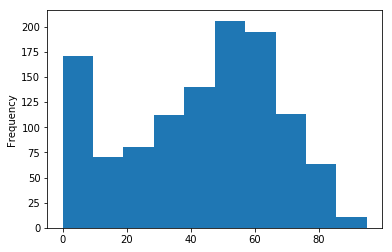

In [0]:
# df['lyric_len'] = df['lyrics'].str.len()
# df.loc[df["lyrics"] == "NA", 'lyric_len'] = 0
# df['lyric_len'].head().mean

## Scrape unlabeled songs

In [0]:
client_credentials_manager = SpotifyClientCredentials(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET)
  
sp_api = sp.Spotify(client_credentials_manager=client_credentials_manager)

In [0]:
genre_seeds = sp_api.recommendation_genre_seeds()

In [0]:
genre_list = genre_seeds['genres']
def scrape_random_songs(target_total):
  all_items = load('random_songs.pkl')
  while len(all_items.keys()) <= target_total:
    seed_genres = random.sample(genre_list, 5)
    print(len(all_items.keys()), seed_genres)
    recc = sp_api.recommendations(
        seed_genres = seed_genres,
        target_energy = random.uniform(0,1),
        max_instrumentalness = max_instrumentalness,
        limit=50
    )
    for item in recc['tracks']:
      all_items[item['id']] = item
    sleep(0.2)
  save(all_items, "random_songs.pkl")

## Get all details about scraped songs

In [0]:
# Scrape audio features
random_tracks = load('random_songs.pkl')
random_track_ids = list(random_tracks.keys())
random_track_items = list(random_tracks.values())
random_track_audio_features = get_audio_features_list(sp_api, random_track_ids)

In [0]:
# Get dict of audio_features
random_track_audio_data = get_track_data_with_audio_features(random_track_audio_features)

In [0]:
# Get dict of track name, artist
random_track_name_dict = get_track_name_dict(random_track_items)

# Update audio dict
random_track_data = random_track_audio_data.copy()
random_track_data.update(random_track_name_dict)

# Get popularity
random_track_data['popularity'] = [item['popularity'] for item in random_track_items]
save(random_track_data,"random_track_data.pkl")

Saved at random_track_data.pkl!


In [0]:
random_track_data = load('random_track_data.pkl')

# Get lyrics and store hashmap
random_lyric_dict, random_lyric_list = get_lyrics(random_track_data['name'], random_track_data['artist'])
# save(random_lyric_dict,"lyrics_dict.pkl")

# Add lyric list and artist ids to data dictionary
random_track_data['lyrics'] = random_lyric_list
random_track_data['artist_id'] = [[artist['id'] for artist in item['artists']] for item in random_track_items]

save(random_track_data,"random_track_data.pkl")

In [0]:
random_track_data = load('random_track_data.pkl')

# Get all genres for each track and store genre hash map
random_track_genre_list, genre_map = get_all_genres(sp_api, random_track_data['artist_id'])
save(genre_map,"genre_map.pkl")

random_track_data['genres'] = random_track_genre_list
save(random_track_data,"random_track_data.pkl")


100%|██████████| 15019/15019 [00:00<00:00, 372003.05it/s]

Saved at genre_map.pkl!
Saved at random_track_data.pkl!


In [0]:
df = load(df, "random_songs_df.pkl")

df['language'] = df['lyrics'].apply(lang_detect)
save(df, "random_songs_df.pkl")